# Exercise B02: Forward models, data generation and forward UQ

In this notebook, we dive into forward models in CUQIpy. In brief, a forward model is defined as a mathematical model that describes the relationship between some input parameters (which are not directly observable) and some output data (which is observable).

In the context of inverse problems, forward models are an important concept. If the forward model is ill-conditioned, it will amplifies noise or uncertainties in the data and the inverse problem then becomes *ill-posed*, which means that existence, uniqueness and/or stability of inversion cannot be guaranteed. This ill-posedness deserves a separate discussion, which is out-of-scope for this notebook and we refer to [1] for the interested reader.

For the purpose of this notebook, we show the basics of how to use forward models in CUQIpy. In particular for generating simulated noisy data and some forward uncertainty quantification. Finally, we also show how to define new custom linear or non-linear forward models in CUQIpy from either a matrix or functions.

## Learning objectives
Going through this notebook you will see how to

* Access and use pre-defined forward models from the CUQIpy testproblem library.
* Carry out basic operations of forward models such as forward evaluation.
* Generate noisy forward simulated data.
* Make a custom forward model from an existing matrix or function.
* Run a simple forward UQ analysis.

## Table of contents
1. [Access forward models from test problems](#testproblems)
2. [Basic usage of forward models](#models)
3. [Generating synthetic data](#data)
4. [Creating custom forward models](#custom)
5. [★ Forward UQ](#forwardUQ)

## References
[1] Hansen, P. C. (2010). Discrete inverse problems: insight and algorithms. Society for Industrial and Applied Mathematics, [10.1137/1.9780898718836](https://epubs.siam.org/doi/book/10.1137/1.9780898718836).

Before getting started, we have to import the Python packages we need. Here we also import CUQIpy (cuqi).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cuqi

# 1. Access forward models from test problems<a class="anchor" id="testproblems"></a>
Forward models in CUQIpy are the link between the parameter of interest (which we call solution), say $\mathbf{x}$, and the observed data, say $\mathbf{y}$. In their simplest form, they are simply a mapping $A: \mathbf{x} \mapsto \mathbf{y}$. In CUQIpy, forward models are so commonly used that we refer to them simply as models.

In addition to providing a mapping for the "forward" operation and potentially the adjoint, a CUQIpy model also contains information on the parametrization of its domain and range, as well as possible gradients and so on. 

To get a better grasp of the extend of CUQIpy models, let us look at a few examples taken from the testproblem library.

A CUQIpy test problem contains all components specifying an inverse problem, including example data. Most test problems can be configured in different ways. A simple way to work with test problems is to return the main components, namely the forward model, the data and dictionary with problem information. 

## 1.1 Deconvolution in 1D

For example, we can set up a [1D Deconvolution test problem](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.testproblem/cuqi.testproblem.Deconvolution1D.html) and return the main components by:

In [2]:
model1, data1, probInfo1 = cuqi.testproblem.Deconvolution1D(dim=64, phantom="sinc").get_components()

Here we define the testproblem with mostly default settings, except for the dimension and phantom type (exact solution).

Calling print around the model gives us some of the most important information about the model:

In [3]:
print(model1)

CUQI LinearModel: Continuous1D(64,) -> Continuous1D(64,).
    Forward parameters: ['x'].


In this case, we see that we are working with a LinearModel (linear in the operator sense), which makes sense for the deconvolution problem. We also see that the domain and range are both parametrized as Continous1D with 64 parameters. Finally, we see that the forward parameter is called 'x'.

The problem info typically contains both the exact synthetic signal `exactSolution` from which the data was produced and the exact simulated data `exactData`:

In [4]:
probInfo1

ProblemInfo with the following set attributes:
['exactData', 'exactSolution', 'infoString']
 infoString: Noise type: Additive Gaussian with std: 0.01

The true signal (before blurring) looks like this:

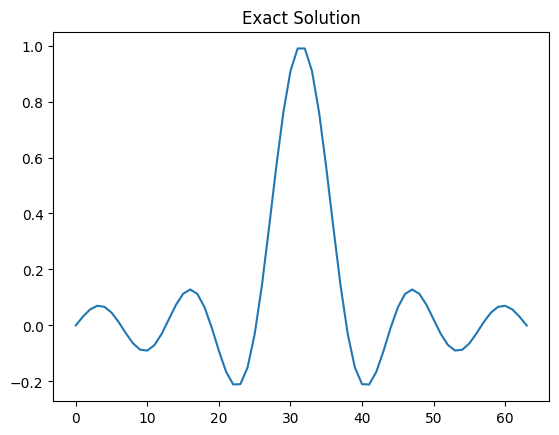

In [5]:
probInfo1.exactSolution.plot()
plt.title("Exact Solution");

We can plot and compare the clean and noisy data:

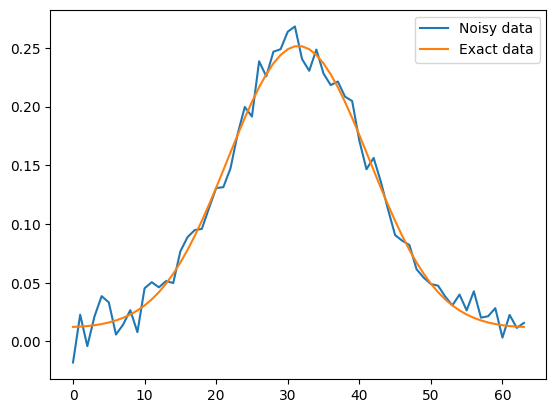

In [6]:
data1.plot(label='Noisy data')
probInfo1.exactData.plot(label='Exact data')
plt.legend()

and easily take a look also at their difference:

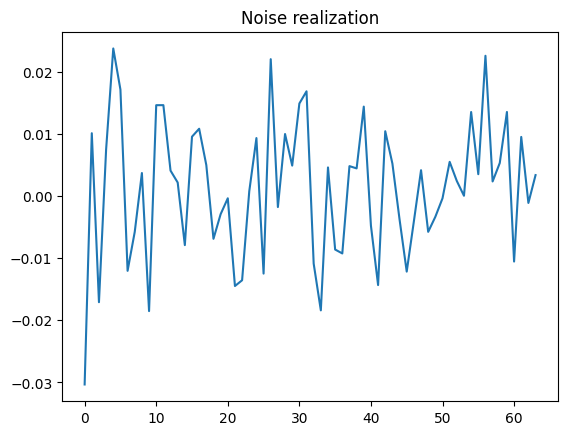

In [7]:
(data1-probInfo1.exactData).plot()
plt.title("Noise realization");

## 1.2 Deconvolution2D: Inverse problem of two-dimensional image deblurring

CUQIpy offers a [2D image deblurring test problem](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.testproblem/cuqi.testproblem.Deconvolution2D.html) as well, which can be set up in the same way as the 1D problem (now with all default settings):

In [8]:
model2, data2, probInfo2 = cuqi.testproblem.Deconvolution2D().get_components()

If we take a look at the model, we see it is a linear model, now with `Image2D` geometries instead of `Continuous1D` as before - the size corresponds to image of size 128x128 = 16384 pixels:

In [9]:
model2

CUQI LinearModel: Image2D(16384,) -> Image2D(16384,).
    Forward parameters: ['x'].

The exact solution is available and `plot` method displays as an image due to the `Image2D` geometry:

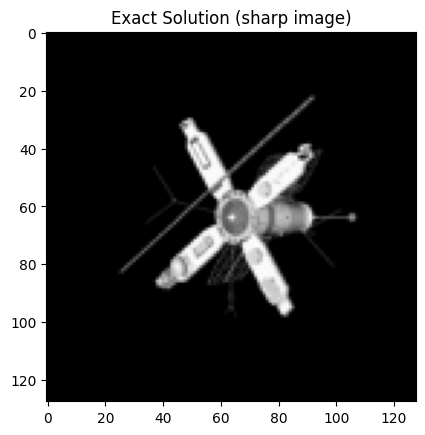

In [10]:
probInfo2.exactSolution.plot()
plt.title("Exact Solution (sharp image)");

Similarly the blurred and noisy data, the clean data and their difference (i.e. the added noise) can be displayed as images:

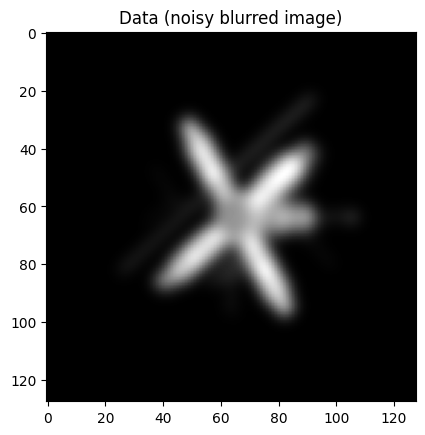

In [11]:
data2.plot()
plt.title("Data (noisy blurred image)");

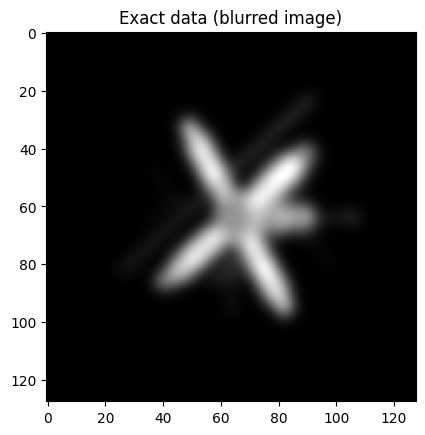

In [12]:
probInfo2.exactData.plot()
plt.title("Exact data (blurred image)")

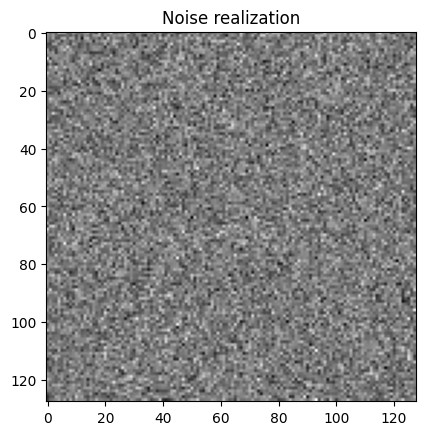

In [13]:
(data2 - probInfo2.exactData).plot()
plt.title("Noise realization");

## 1.3 Heat1D: A model for a PDE-based inverse problem

A completely different test problem is [The 1D heat test problem](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.testproblem/cuqi.testproblem.Heat1D.html), which is described by a partial differential equation (PDE), namely the heat equation. The forward model of `Heat1D` maps an initial temperature distribution on an interval to the temperature distribution after a specified amount of time has passed, by solving the 1D heat equation. For more details, see [Notebook 5](../PDE/PDE01_Exercise_PDE.ipynb). 

Here, we simply set up the test problem in the same way as before:

In [14]:
modelH, dataH, probInfoH = cuqi.testproblem.Heat1D().get_components()

We start by plotting the exact solution, i.e., the true initial temperature distribution over the interval:

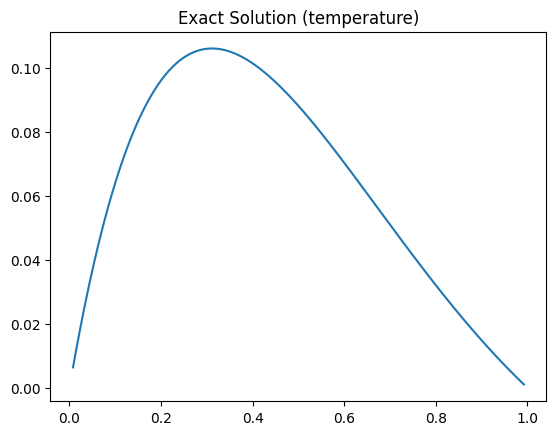

In [15]:
probInfoH.exactSolution.plot()
plt.title("Exact Solution (temperature)");

The data is the noisy observations of the temperature distribution after some time has passed (notice the difference in y-axis values). We plot the data and the exact data as well as their difference:

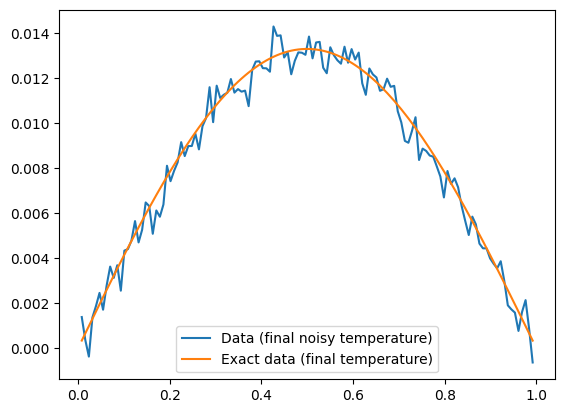

In [16]:
dataH.plot(label="Data (final noisy temperature)")
probInfoH.exactData.plot(label="Exact data (final temperature)")
plt.legend()

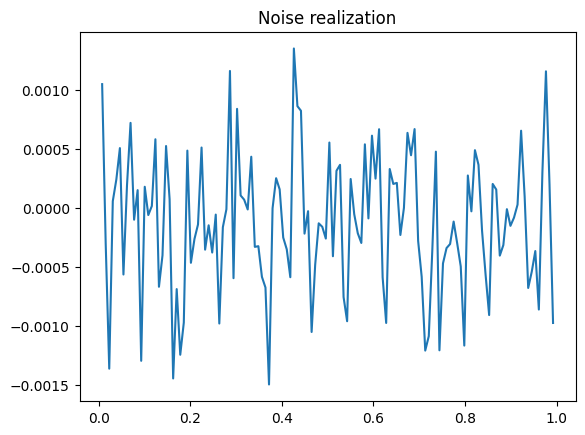

In [17]:
(dataH - probInfoH.exactData).plot()
plt.title("Noise realization");

We can take a closer look at the model:

In [18]:
print(modelH)

CUQI PDEModel: Continuous1D(128,) -> Continuous1D(128,).
    Forward parameters: ['x'].
    PDE: TimeDependentLinearPDE.


Here the domain and range are parametrized as Continuous1D with 128 parameters, and the model is now noted as PDEModel and a new field for a PDE is listed.

A PDEModel in CUQIpy is a model where in each forward computation a PDE is 1) assembled, 2) solved and 3) observed. The specifics would depend on the underlying PDE. With that in mind, let us have a look at the underlying PDE for this PDEModel.

In [19]:
modelH.pde

CUQI TimeDependentLinearPDE.
PDE form expression:
        def PDE_form(IC, t): return (Dxx, np.zeros(N), IC)

Here we see that the underlying PDE is a time-dependent linear PDE which makes sense for the 1D heat testproblem. We could keep exploring PDEModels, but we leave that to our specific notebook on [PDEs](../PDE/PDE01_Exercise_PDE.ipynb).

For now, the main message is that the CUQIpy model provides an abstract representation of a forward model of many and different inverse problems, and that CUQIpy offers a collection of test problems containing forward models, data and exact solutions that can be used for demonstration and benchmarking.

# 2 Basic usage of models <a class="anchor" id="models"></a>
In this section we demonstrate common operations with CUQIpy models. Let us focus on the `LinearModel` representing the convolution operation from the deconvolution test problem.

To simplify notation, let us define this model simply as $\mathbf{A}$ (but remember this is a CUQIpy model, not a matrix) and let us define the exact solution as $\mathbf{x}_\mathrm{exact}$.

In [20]:
A,_,probInfo = cuqi.testproblem.Deconvolution1D(dim=64, phantom="sinc").get_components()
x_exact = probInfo.exactSolution

One of the most basic usages of a CUQIpy model is to evaluate the forward map. This is simply done by calling the `.forward` method, or in the case of a `LinearModel` the short-hand "@" (matrix multiply in Python) can also be used.

In [21]:
y_exact  = A.forward(x_exact) # Explicitly call the forward method
y_exact  = A@x_exact          # Can also use short-hand for matrix multiply (gives the same result)

Linear model also supports basic operations such as evaluating the adjoint, which can also be done using the numpy-like syntax ".T" for transpose. For example here we apply the adjoint operator of `A` to `y_exact`.

In [22]:
z = A.adjoint(y_exact) # Explicitly call the adjoint method
z = A.T@y_exact        # Can also use short-hand for matrix transpose (gives the same result)

Unlike distributions or CUQIarrays, which have only one geometry attribute, forward models are distinct in having two geometries. `domain_geometry` relates to the domain of the forward mapping, and `range_geometry` relates to the range. These geometries play an important role in linking samplers, which deal with single vectors, to forward models, which are geared towards handling more complex data structures.

For example, let us take a look at the range geometry of `A`:

In [23]:
A.range_geometry

Continuous1D(64,)

When computing the forward operation, `A` passes its range geometry to the output. We can validate this by inspecting `y_exact` from earlier.

In [24]:
y_exact.geometry

Continuous1D(64,)

This allows plotting in the correct geometry immediately after forward computation

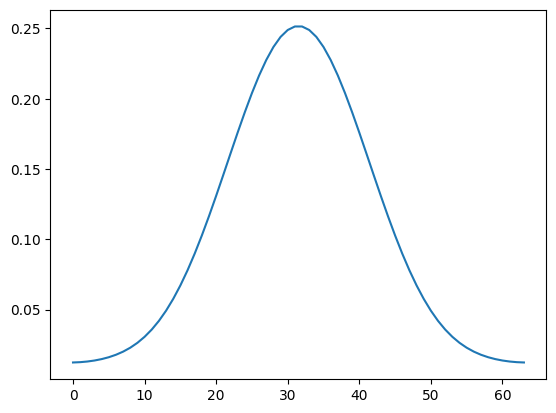

In [25]:
y_exact.plot();

It can be useful to change to domain or range geometries of a model, for example to work with different parametrizations or simply for visualization purposes.

Here we change the range geometry of the model to [Discrete](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.geometry/cuqi.geometry.Discrete.html) and see this reflected in the plotting of the computed output:

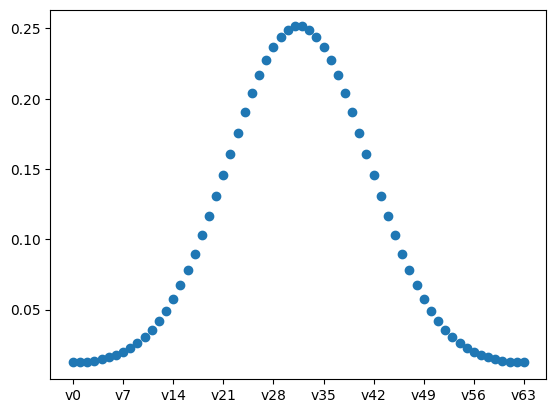

In [26]:
A.range_geometry = cuqi.geometry.Discrete(A.range_dim)
A.forward(x_exact).plot()

Note that since we are only interested in generating a plot here, we do not need to store a new variable for `y_exact`, but rather just immediately call the `plot` method in the same line.

Here we also used `A.range_dim` to get not the range geometry but the dimension of it. Similarly, we can ask for the dimension of the domain geometry:

In [27]:
A.domain_dim

64

Some `LinearModel` objects simply contain a matrix representing the linear mapping; while others use a matrix-free approach. In both cases, one can extract the matrix of the linear model by (this will raise an error if the model is too large):

In [28]:
A.get_matrix()

<64x64 sparse matrix of type '<class 'numpy.float64'>'
	with 4096 stored elements in Compressed Sparse Column format>

Finally, models can also be applied to [Samples objects](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.samples/cuqi.samples.Samples.html#cuqi.samples.Samples), for example to evaluate the forward on all samples. This can be used for forward UQ as shown in Section 5 of this notebook.

Given a distribution and some samples generated from it:

In [29]:
x = cuqi.distribution.Gaussian(np.zeros(A.domain_dim), cov=1)

In [30]:
xs = x.sample(1000)
print(type(xs))
xs.shape

<class 'cuqi.samples._samples.Samples'>


(64, 1000)

i.e. 1000 samples each of size 64 matching the domain of `A`. We can apply `A` directly to the Samples object:

In [31]:
ys = A@xs

We plot a couple of selected samples from x:

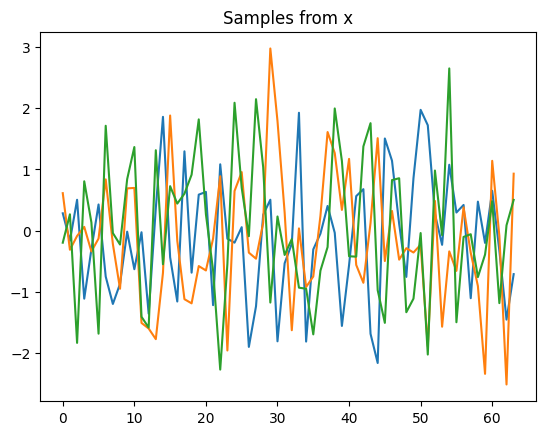

In [32]:
xs.plot([100,200,300])
plt.title("Samples from x");

and plot the same samples from y:

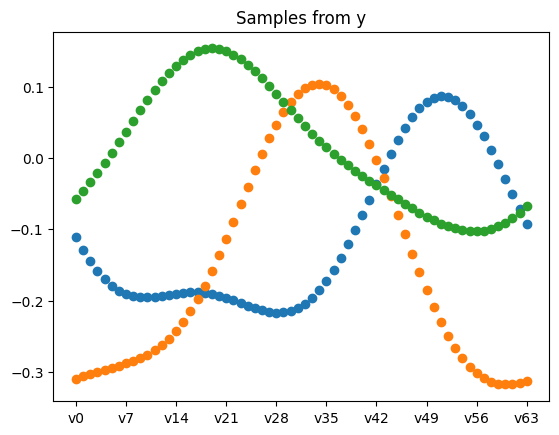

In [33]:
ys.plot([100,200,300])
plt.title("Samples from y");

where we note the computed samples ys = A(xs) have the Discrete geometry as `A` is now equipped with.

#### ★ Try yourself (optional):  
Try modifying the range geometry of `A` to a `Continuous2D` and plotting the resulting samples `ys = A(xs)`. 

**Hint:** Continuous2D can created with a tuple of integers defining the size of each dimension, e.g. to define a 8 by 8 geometry `cuqi.geometry.Continuous2D((8,8))`

In [122]:
# This is where you type the code:

A.range_geometry = cuqi.geometry.Continuous2D((8,8))


In [123]:
ys = A(xs)

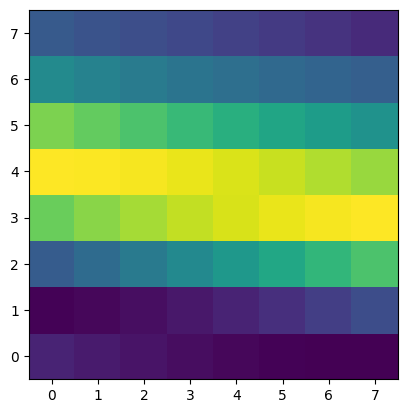

In [124]:
ys.plot([100])

# 3. Generating synthetic data <a class="anchor" id="data"></a>

One of the main tasks when working on numerical experiments for inverse problems is to generate synthetic data (potentially many realizations) to test and validate against. 

In this section, we demonstrate one way this can be achieved by defining the *data distribution*.

Let us return to the forward model from the deconvolution testproblem from earlier, and assume that the measurement data is affected by additive i.i.d. Gaussian noise with standard deviation $0.05$. This leads to the Bayesian model for the inverse problem

$$\mathbf{y} = \mathbf{A}\mathbf{x}+\mathbf{e},$$

where $\mathbf{y}$, $\mathbf{x}$ and $\mathbf{e}$ are random variables and where the goal now is to generate examples of observed data assuming $\mathbf{e}\sim \mathcal{N}(\mathbf{0},0.05^2\mathbf{I})$ and given some exact solution vector $\mathbf{x}_\mathrm{exact}$.

**Note** *Generating noisy data in the above example with additive Gaussian noise is rather straightforward. However, the focus here is to provide a common framework for a much larger variety of models and noise types - exemplified by the Gaussian case.*

## 3.1 Data distribution
First, note that since $\mathbf{e}$ is the only random contribution to $\mathbf{y}$ when $\mathbf{x}$ is fixed we can directly see that 

$$\mathbf{y} \mid \mathbf{x} \sim \mathcal{N}(\mathbf{A}\mathbf{x}, 0.05^2 \mathbf{I}).$$

We call the distribution $p(\mathbf{y} \mid \mathbf{x})$ associated with $\mathbf{y} \mid \mathbf{x}$ a *data distribution*. 
To generate synthetic data from $\mathbf{x}_\mathrm{exact}$, we are thus interested in sampling from
$p(\mathbf{y} \mid \mathbf{x}=\mathbf{x}_\mathrm{exact})$.

Let us use the phantom from probInfo and extract the model again from the testproblem (just in case some changes were made above)

In [35]:
n = 64
A, _, probInfo = cuqi.testproblem.Deconvolution1D(dim=n, phantom="sinc").get_components()
x_exact = probInfo.exactSolution

The data distribution is conditioned on $\mathbf{x}$ and so we need to represent a conditional distribution in CUQIpy. 

Luckily, when $\mathbf{A}$ is represented by a CUQIpy model this is easy as we simply provide the model in place of $\mathbf{A}\mathbf{x}$ as follows.

In [36]:
y = cuqi.distribution.Gaussian(mean=A, cov=0.05**2)

Recall from earlier that the model `A` had its forward parameter given by 'x':

In [37]:
print(A)

CUQI LinearModel: Continuous1D(64,) -> Continuous1D(64,).
    Forward parameters: ['x'].


If we now inspect `y`, we see that it has become a conditional distribution, conditioned on that same 'x' parameter.

In [38]:
print(y)

CUQI Gaussian. Conditioning variables ['x'].


Note that the mean of the Gaussian is really `A*x`, but since `x` is the forward parameter of `A`, this is implied. 

When working multiple distributions, one can be more explicit about the parameter to the forward model by explicitly `evaluating` the forward model with the desired distribution as input. In this way the forward parameter can also be changed from e.g. the default `x` to `u`:

In [39]:
u = cuqi.distribution.Gaussian(np.zeros(n), cov=1)

and using `u` we can now specify the mean `Au`:

In [40]:
yu = cuqi.distribution.Gaussian(mean=A@u, cov=0.05**2)
yu

CUQI Gaussian. Conditioning variables ['u'].

and we see that `u` is now the conditioning variable instead of `x`.

## 3.2 Sampling a data distribtuion

Evaluating a conditional distribution in CUQIpy is done by use of the "call" method on Python. That is, for a data distribution we would write `y(x=x_exact)` or simply `y(x_exact)`.

Evaluating the conditional distribution creates a new distribution, where the conditioning variable is fixed. That is, one can think of the expression `y(x=x_exact)` as defining $p(\mathbf{y} \mid \mathbf{x}=\mathbf{x}_\mathrm{exact})$. 

Hence to simulate some noisy data, we just provide the conditioning variable `x_exact` to the data distribution and then sample.

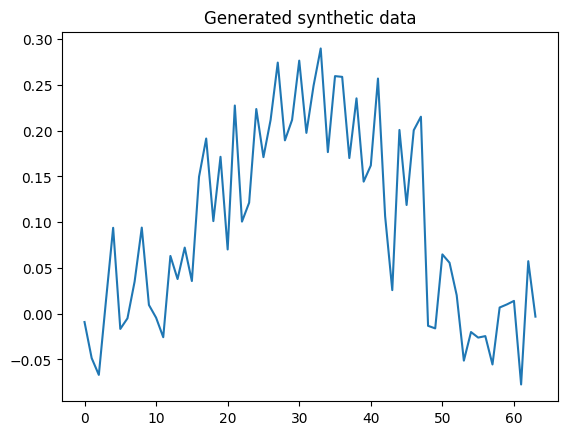

In [41]:
y_obs = y(x=x_exact).sample()
y_obs.plot();
plt.title("Generated synthetic data");

#### Try yourself (optional):  
The above example may seem like a rather extensive way to generate noisy data when the noise is additive Gaussian (and it is for this simple case!).

Using the CUQIpy framework, try simulating data from the case where the data distribution follows a [Laplace distribution](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.distribution/cuqi.distribution.Laplace.html#cuqi.distribution.Laplace) with location $\mathbf{A}\mathbf{x}$ and scale $0.2$.

In [120]:
# This is where you type the code:
y = cuqi.distribution.Laplace(A@x, 0.2)

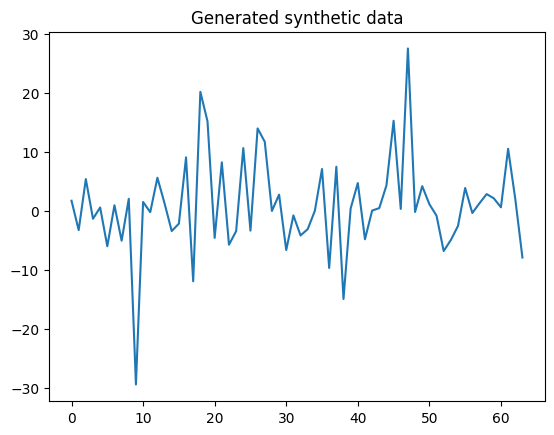

In [121]:
y_obs = y(x=x_exact).sample()
y_obs.plot();
plt.title("Generated synthetic data");

## 4. Creating custom forward models <a class="anchor" id="custom"></a>

## 4.1 Defining model from a matrix

Defining a CUQIpy model from a matrix is easy. Suppose we have the matrix representing the forward operator of the following simple linear inverse problem, which is akin to a sudoko puzzle representing simple Computed Tomography.

Consider a 2x2 square with unknown pixel values, to be determined from the row and column sums:

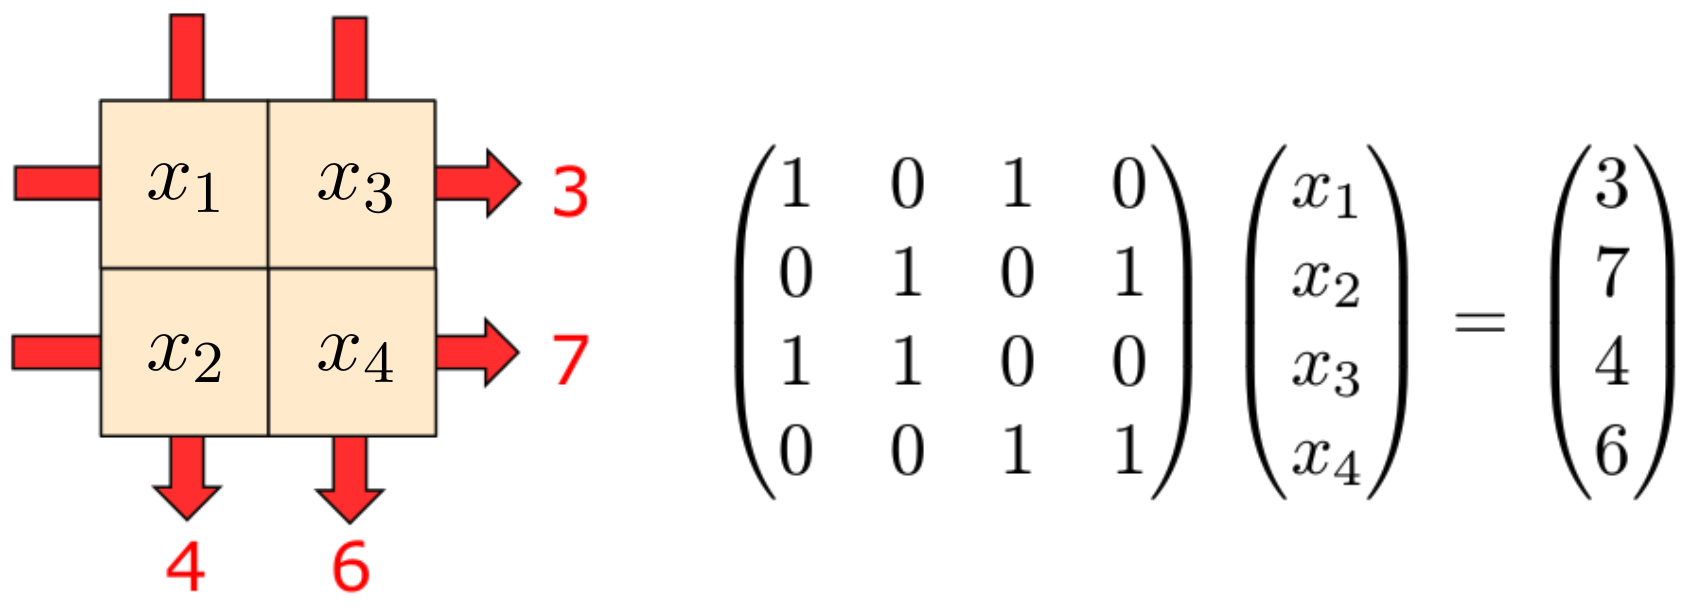

In [43]:
#Create a numpy matrix to act like a forward model (this matrix can be replaced to represent other problems)
mat = np.array([
    [1,0,1,0],
    [0,1,0,1],
    [1,1,0,0],
    [0,0,1,1]
])

To create a CUQIpy model represented by this matrix, all we have to do is pass it to the `LinearModel` class from the `model` module in CUQIpy as follows.

In [44]:
model_mat = cuqi.model.LinearModel(mat)
print(model_mat)

CUQI LinearModel: _DefaultGeometry1D(4,) -> _DefaultGeometry1D(4,).
    Forward parameters: ['x'].


Here the range and domain geometry is inferred from the matrix. If we want to, we can pass in more explicit information about the range and domain geometries. Here we choose to represent the domain geometry of the four pixel values as a [Image2D](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.geometry/cuqi.geometry.Image2D.html) geometry:

In [45]:
geom1 = cuqi.geometry.Image2D((2,2), order="F", visual_only=True)
geom1

Image2D(4,)

To match the picture above, we select the column-major order by defining `order="F"` (F comes from Fortran for historical reasons).

By default `Image2D` converts the input to an image before being evaluated by the model. In our case the matrix expects a vector, so we do not want this default behavior and thus set `visual_only=True` to not convert the vector to an image before model evaluation.

We can create an example 2x2 solution as a CUQIarray equipped with the geometry:

In [46]:
im1 = cuqi.array.CUQIarray([7,5,3,1], geometry=geom1)
im1

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 Image2D(4,)

Parameters:
 True

Array:
CUQIarray([7, 5, 3, 1])

which will allow us to display it nicely, even through it is a stored as a vector:

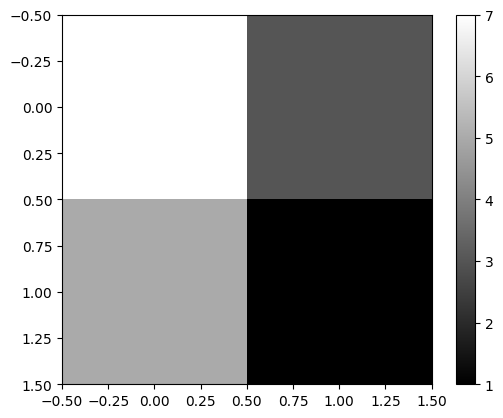

In [47]:
im1.plot()
plt.colorbar()

The row and column sum data we can - for the purpose of the example - let be of the type Discrete (labelled) geometry:

In [48]:
geom2 = cuqi.geometry.Discrete(['row1','row2','col1','col2'])

We set up and display the observed data from the figure above:

In [49]:
data = cuqi.array.CUQIarray([3,7,4,6], geometry=geom2)
data

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 Discrete(4,)

Parameters:
 True

Array:
CUQIarray([3, 7, 4, 6])

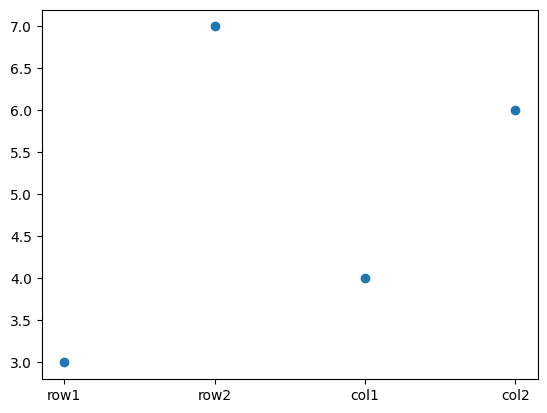

In [50]:
data.plot()

We can equip our model with the geometries for its domain and range

In [51]:
model_mat.domain_geometry = geom1
model_mat.range_geometry = geom2
model_mat

CUQI LinearModel: Image2D(4,) -> Discrete(4,).
    Forward parameters: ['x'].

which will allow to apply the forward to an image as if it were a matrix:

In [52]:
data1 = model_mat@im1
data1

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 Discrete(4,)

Parameters:
 True

Array:
CUQIarray([10,  6, 12,  4])

Note the resulting `data1` automatically has the desired geometry.

We can compare the data computed from `im1` against the observed data:

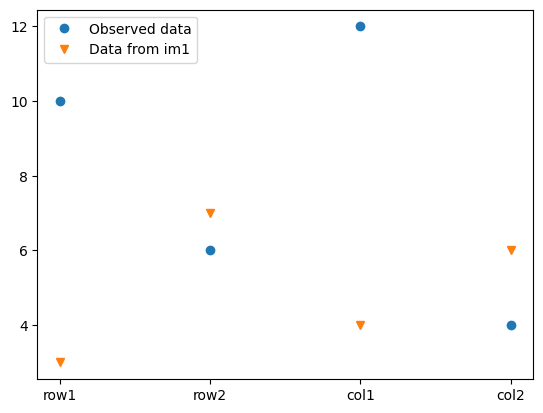

In [53]:
data1.plot()
data.plot(marker="v")
plt.legend(["Observed data", "Data from im1"])

We can also apply the adjoint using matrix transpose notation:

In [54]:
adjoint_data = model_mat.T@data1
adjoint_data

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 Image2D(4,)

Parameters:
 True

Array:
CUQIarray([22, 18, 14, 10])

and we can visualize the adjoint data (which should be in the domain geometry of A)

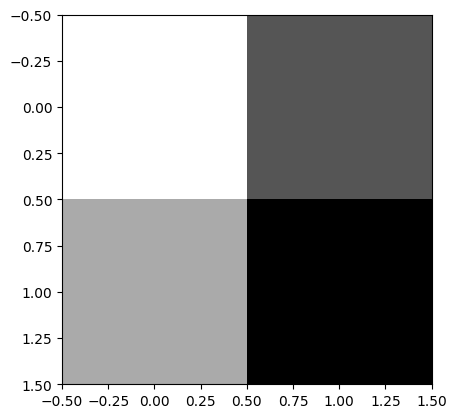

In [55]:
adjoint_data.plot()

### Optional exercise: 
- Try out different values for the four elements of `im1` to find a set that produces the observed data.
- Note there is more than one solution. Can you describe all the solutions?

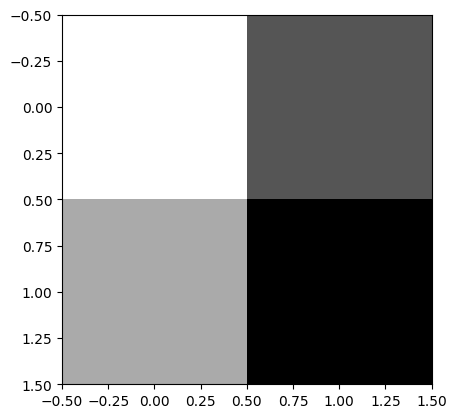

In [132]:
cuqi.array.CUQIarray([7,5,3,1], geometry=geom1).plot()

In [135]:
np.invert(mat)

array([[-2, -1, -2, -1],
       [-1, -2, -1, -2],
       [-2, -2, -1, -1],
       [-1, -1, -2, -2]])

## 4.2 Defining model from a function
We can also define CUQIpy models from functions. In this case, we must at the minimum provide the dimensions of the range and domain, for example

In [56]:
#This can be any function representing the forward computation. Here just a random function with 3 inputs and 2 outputs
def my_func(x):
    return np.array([x[0]**2+x[1], x[1]+x[2]])

We could provide any geometry of size 2 for the range and size 3 for the domain - here we use the short-hand integer notation to specify uninformative default geometries that only represent the dimension:

In [57]:
model_func = cuqi.model.Model(my_func, range_geometry=2, domain_geometry=3)
print(model_func)

CUQI Model: _DefaultGeometry1D(3,) -> _DefaultGeometry1D(2,).
    Forward parameters: ['x'].


Models will work both on simple numpy arrays and CUQIarrays. Numpy arrays will produce numpy array out:

In [58]:
in1 = np.array([3.0, 2.0, 1.0])
out1 = model_func(in1)
print(out1)
type(out1)

[11.  3.]


numpy.ndarray

Passing a CUQIarray in produces a CUQIarray out:

In [59]:
in2 = cuqi.array.CUQIarray(in1)
in2

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 _DefaultGeometry1D(3,)

Parameters:
 True

Array:
CUQIarray([3., 2., 1.])

In [60]:
out2 = model_func(in2)
out2

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 _DefaultGeometry1D(2,)

Parameters:
 True

Array:
CUQIarray([11.,  3.])

## 4.3 Linear model from functions

If we have function for both the forward and adjoint, we can also specify a LinearModel from these functions. Here we illustrate by creating a forward and adjoint function from the matrix given earlier

In [61]:
def mat_forward(x):
    return mat@x

def mat_adjoint(y):
    return mat.T@y

In this case, the range and domain dimensions (or geometry) cannot be inferred, so they also need to be defined

In [62]:
model_linear_func = cuqi.model.LinearModel(forward=mat_forward, adjoint=mat_adjoint, range_geometry=4, domain_geometry=4)
print(model_linear_func)

CUQI LinearModel: _DefaultGeometry1D(4,) -> _DefaultGeometry1D(4,).
    Forward parameters: ['x'].


The new linear model can then be applied to numpy arrays (or CUQIarrays if including geometries):

In [63]:
z1 = np.array([1., 2., 3., 4.])
z2 = model_linear_func(z1)
z2

array([4., 6., 3., 7.])

and the adjoint function is also available:

In [64]:
model_linear_func.T(z2)

array([ 7.,  9., 11., 13.])

# 5. ★ Forward UQ <a class="anchor" id="forwardUQ"></a>
In some cases, it may be interesting to see the effect a chosen prior has on the data-side, a so-called forward UQ analysis. This can easily be achieved using CUQIpy models and distributions. 

For this case, let us assume we have the data created from $\mathbf{x}_\mathrm{exact}$ earlier, and we want to see if the prior encapsulates the measured data if we push it through forward model (ignoring noise in this case).

To do this, we first define our prior and generate some samples from it

In [65]:
# Number of samples (try changing this)
Ns = 200

# Building blocks for defining Gaussian mean
z = np.zeros(20); o = 0.5*np.ones(24) 

# Prior distribution
x = cuqi.distribution.Gaussian(np.hstack((z,o,z)),0.5)

# Sample prior
xs = x.sample(Ns)

We then plot a credibility interval for the prior and compare with $\mathbf{x}_\mathrm{exact}$. 

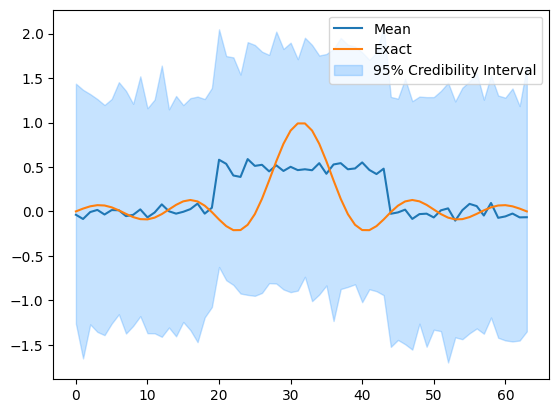

In [66]:
xs.plot_ci(95, exact=x_exact)

To perform the forward UQ analysis and compare on the data-side, we essentially have to compute the forward for each sample.

This would normally be done with for loop. However, because `xs` is a CUQIpy samples object and `A` is CUQIpy model, we can simply call the forward on the entire samples object (where once again the range geometry is passed from the model to the Samples on the data side).

In [67]:
ys = A.forward(xs) #Notation A@xs or even A(xs) would also have worked

We then compare the *push-forward* samples with the data generated earlier

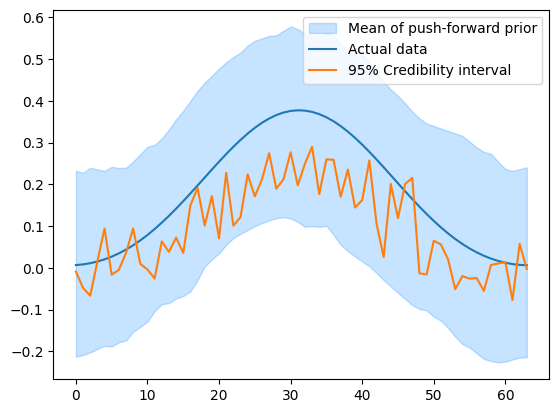

In [68]:
ys.plot_ci(95, exact=y_obs)
plt.legend(['Mean of push-forward prior', 'Actual data', '95% Credibility interval', ])

In this case the actual data is within the credibility interval of the push-forward prior, which is a good sign that the prior is a good representation of
the exact solution.

This kind of forward UQ analysis is the stepping stone to the more general prior-predictive analysis, which we leave for future tutorials.